In [403]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re 
import json
from sklearn.linear_model import LogisticRegression

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from scipy.stats import pearsonr
from scipy.stats import shapiro
from sklearn.decomposition import PCA
from typing import Literal
from sklearn.preprocessing import Normalizer, StandardScaler

In [404]:
# pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.inf)

# Import Data

In [405]:
data = pd.read_csv('../data/welddb.data', sep=' ', header=None)
data.shape

(1652, 44)

In [406]:
def replace_data(df):
    df.replace('N', np.nan, inplace=True)
    return df

In [407]:
column_names = [
    "Carbon_concentration",
    "Silicon_concentration",
    "Manganese_concentration",
    "Sulphur_concentration",
    "Phosphorus_concentration",
    "Nickel_concentration",
    "Chromium_concentration",
    "Molybdenum_concentration",
    "Vanadium_concentration",
    "Copper_concentration",
    "Cobalt_concentration",
    "Tungsten_concentration",
    "Oxygen_concentration",
    "Titanium_concentration",
    "Nitrogen_concentration",
    "Aluminium_concentration",
    "Boron_concentration",
    "Niobium_concentration",
    "Tin_concentration",
    "Arsenic_concentration",
    "Antimony_concentration",
    "Current",
    "Voltage",
    "AC_or_DC",
    "Electrode_positive_or_negative",
    "Heat_input",
    "Interpass_temperature",
    "Type_of_weld",
    "Post_weld_heat_treatment_temperature",
    "Post_weld_heat_treatment_time",
    "Yield_strength",
    "Ultimate_tensile_strength",
    "Elongation",
    "Reduction_of_Area",
    "Charpy_temperature",
    "Charpy_impact_toughness",
    "Hardness",
    "50%_FATT",
    "Primary_ferrite_in_microstructure",
    "Ferrite_with_second_phase",
    "Acicular_ferrite",
    "Martensite",
    "Ferrite_with_carbide_aggregate",
    "Weld_ID"
]

sulphur_and_phosphorus_columns = ["Sulphur_concentration","Phosphorus_concentration"]

other_concentration_columns = ["Carbon_concentration",
        "Silicon_concentration",
        "Manganese_concentration",
        "Nickel_concentration",
        "Chromium_concentration",
        "Molybdenum_concentration",
        "Vanadium_concentration",
        "Copper_concentration",
        "Cobalt_concentration",
        "Tungsten_concentration",
        "Oxygen_concentration",
        "Titanium_concentration",
        "Nitrogen_concentration",
        'Nitrogen_concentration_residual',
        "Aluminium_concentration",
        "Boron_concentration",
        "Niobium_concentration",
        "Tin_concentration",
        "Arsenic_concentration",
        "Antimony_concentration"]

label_names = ['Yield_strength', 'Ultimate_tensile_strength', 'Elongation', 'Reduction_of_Area', 'Charpy_temperature', 
                   'Charpy_impact_toughness', 'Hardness', '50%_FATT', 'Primary_ferrite_in_microstructure', 'Ferrite_with_second_phase', 
                   'Acicular_ferrite', 'Martensite', 'Ferrite_with_carbide_aggregate', 'Hardness_load']

physical_ordinal_properties_columns = [
        'Current', 
        'Voltage',
        'Heat_input',
        'Interpass_temperature',
        'Post_weld_heat_treatment_temperature',
        'Post_weld_heat_treatment_time', 
    ]

physical_categorical_properties_columns = [
    'AC_or_DC',
    'Electrode_positive_or_negative',
    'Type_of_weld'
]

data.columns = column_names

# Copy the initial dataset to apply transformations
def choose_labels(df, labels_chosen):
    df["Hardness_load"] = np.nan
    df["Nitrogen_concentration_residual"] = 0
    labels = df[labels_chosen]
    inputs = df.drop(columns=label_names + ['Weld_ID'])
    return inputs, labels

data_copy = data.copy()
data_copy= replace_data(data_copy)
inputs, outputs = choose_labels(df=data_copy, labels_chosen="Yield_strength")

# Infos

In [408]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 44 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Carbon_concentration                  1652 non-null   float64
 1   Silicon_concentration                 1652 non-null   float64
 2   Manganese_concentration               1652 non-null   float64
 3   Sulphur_concentration                 1652 non-null   object 
 4   Phosphorus_concentration              1652 non-null   object 
 5   Nickel_concentration                  1652 non-null   object 
 6   Chromium_concentration                1652 non-null   object 
 7   Molybdenum_concentration              1652 non-null   object 
 8   Vanadium_concentration                1652 non-null   object 
 9   Copper_concentration                  1652 non-null   object 
 10  Cobalt_concentration                  1652 non-null   object 
 11  Tungsten_concentr

# Data Cleaning

## Structural Errors

In [409]:
i = 0
for column in data.columns:
    print(i)
    print(column)
    print(data[column].unique())
    i+=1

0
Carbon_concentration
[0.037  0.044  0.045  0.039  0.041  0.051  0.049  0.038  0.043  0.053
 0.046  0.048  0.074  0.075  0.076  0.068  0.081  0.079  0.078  0.069
 0.08   0.071  0.072  0.066  0.067  0.09   0.088  0.091  0.089  0.094
 0.086  0.04   0.047  0.052  0.05   0.054  0.073  0.077  0.07   0.062
 0.06   0.055  0.059  0.042  0.058  0.065  0.095  0.151  0.147  0.145
 0.061  0.035  0.1    0.12   0.099  0.093  0.101  0.096  0.097  0.03
 0.032  0.031  0.098  0.13   0.11   0.057  0.15   0.064  0.082  0.036
 0.125  0.105  0.115  0.1055 0.14   0.16   0.084  0.092  0.029  0.063
 0.18  ]
1
Silicon_concentration
[0.3   0.31  0.35  0.33  0.32  0.36  0.29  0.34  0.39  0.44  0.48  0.37
 0.51  0.57  0.27  0.45  0.24  0.41  0.46  0.43  0.42  0.52  0.54  0.18
 0.17  0.2   0.22  0.4   0.26  0.25  0.53  0.38  0.28  0.47  0.23  0.16
 0.62  0.68  0.59  0.7   0.56  0.5   0.58  0.66  0.63  0.67  0.61  0.21
 0.49  0.12  0.13  0.15  0.11  0.19  0.14  0.415 0.08  0.04  0.07  0.55
 0.9   0.8   1.14  0.95  

In [411]:
def sum_values_inferior_to_value(data):
    # Dictionary to store for each the maximum value of the column sum_less_than
    mean_values = {}
    values = data.unique()
    for value in values:
        mean_values[value] = data[data <= value].sum() / data[data <= value].shape[0]
    
    return mean_values


# Values < N
def replace_less_than_values(*, df, column, strategy):
    if df[column].any() and type(df[column].dropna().iloc[0]) == str:  # Check if the column contains string values:
        new_column = column + '_<'  # Create a new column name
        df[new_column] = np.nan  # Create a new column to store the boolean values
        
        # Apply the transformation using .loc to avoid SettingWithCopyWarning
        mask = df[column].apply(lambda x: isinstance(x, str))
        df.loc[mask, column + '_<'] = df.loc[mask, column].str.contains('<')
        df.loc[mask, column] = df.loc[mask, column].replace('<', '', regex=True)
        
        if strategy=='max':
            # Replace the values in the column by the max value
            df.loc[df[new_column] == True, column] = df.loc[df[new_column] == True, column].apply(lambda x: float(x))
        elif strategy=='mean' and df.loc[df[new_column] == True, column].shape[0] > 0:
            # Replace the values in the column by the mean value of the values inferior to max value
            mean_values = sum_values_inferior_to_value(df.loc[df[column].notna(), column].apply(lambda x: float(x)))
            df.loc[df[new_column] == True, column].map(mean_values)

        df.drop(column + '_<', axis=1, inplace=True)
    return df

# Values like 158(Hv30) or 67tot33res
def split_res_values(value, pattern):
    if isinstance(value, str) and pattern in value:
        # Looking for two numbers in the string 
        numbers = re.findall(r'\d+', value)
        if len(numbers) > 1:
            return float(numbers[0]), float(numbers[1])
        else:
            return float(numbers[0]), np.nan  # If only one number is before "res"
    else:
        try:
            return float(value), np.nan  # If there is no "res", return NaN
        except ValueError:
            return np.nan, np.nan

# Values like 150 - 200
def process_interpass_temperature(value):
        if isinstance(value, str) and '-' in value:
            # Split the range, convert to integers, and calculate the mean
            low, high = map(int, value.split('-'))
            return int((low + high) / 2)
        else:
            # Try converting the value to int, or return NaN if not possible
            try:
                return int(value)
            except (ValueError, TypeError):
                return np.nan
            
# Handling columns with two numerical values 
def process_string_values(*, inputs, outputs, less_than_value_strategy, labels_chosen):
    for column in inputs.columns:
        inputs = replace_less_than_values(df=inputs, column=column, strategy=less_than_value_strategy)
    inputs['Nitrogen_concentration'], inputs['Nitrogen_concentration_residual'] =  zip(*inputs['Nitrogen_concentration'].apply(lambda x:split_res_values(x, 'res')))
    if 'Hardness' in labels_chosen:
        outputs['Hardness'], outputs['Hardness_load'] =  zip(*outputs['Hardness'].apply(lambda x:split_res_values(x, 'Hv')))
    inputs['Interpass_temperature'] = inputs['Interpass_temperature'].apply(process_interpass_temperature)
    return inputs, outputs

data_copy, _ = process_string_values(inputs=inputs, outputs=outputs, less_than_value_strategy='mean', labels_chosen="Yield_strength")

In [412]:
# Converting string values that are actually numeric
def convert_to_numeric_values(df):
    for column in data.columns:
        try:
            df[column] = pd.to_numeric(df[column])
        except Exception:
            continue
    return df
# Checking if the the values were converted to float without damaging other columns
data_copy = convert_to_numeric_values(data_copy)
print(data_copy.info())
data_copy.head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Carbon_concentration                  1652 non-null   float64
 1   Silicon_concentration                 1652 non-null   float64
 2   Manganese_concentration               1652 non-null   float64
 3   Sulphur_concentration                 1648 non-null   float64
 4   Phosphorus_concentration              1642 non-null   float64
 5   Nickel_concentration                  697 non-null    float64
 6   Chromium_concentration                784 non-null    float64
 7   Molybdenum_concentration              793 non-null    float64
 8   Vanadium_concentration                928 non-null    float64
 9   Copper_concentration                  578 non-null    float64
 10  Cobalt_concentration                  129 non-null    float64
 11  Tungsten_concentr

<bound method NDFrame.head of       Carbon_concentration  Silicon_concentration  Manganese_concentration  \
0                   0.0370                  0.300                     0.65   
1                   0.0370                  0.300                     0.65   
2                   0.0370                  0.300                     0.65   
3                   0.0370                  0.310                     1.03   
4                   0.0370                  0.310                     1.03   
5                   0.0370                  0.310                     1.03   
6                   0.0440                  0.350                     1.43   
7                   0.0440                  0.350                     1.43   
8                   0.0440                  0.350                     1.43   
9                   0.0450                  0.330                     1.85   
10                  0.0450                  0.330                     1.85   
11                  0.0450        

## Missing values

## Imputation

### Concentrations: P (Phosphorus) and S (Sulfur) with mean values

<div class="alert alert-block alert-success">
<b>Why to do this ?</b>
Phosphorus and sulfur are usually present in steel, even if they aren't deliberately added. These elements are often impurities, and their concentrations are small but non-zero in most cases. When their values are missing in the data, the assumption is that they were not measured but still exist at some average level. Thus, the authors use the mean concentration as a reasonable estimate for missing values.

**Source**:
Source: The yield and ultimate tensile strength of steel welds - Tracey Cool a,*, H.K.D.H. Bhadeshia a, D.J.C. MacKay b 
</div>

In [413]:
# Instantiate a transformer for mean imputation.
def missing_values_sulphur_and_phosphorus(df):

    imp_mean = SimpleImputer(strategy='mean')
    df[sulphur_and_phosphorus_columns] = imp_mean.fit_transform(df[sulphur_and_phosphorus_columns])

    return df

data_copy = missing_values_sulphur_and_phosphorus(data_copy)

### Other concentrations (e.g., Mn, Ni, etc.) by setting them to 0

<div class="alert alert-block alert-success">
<b>Why to do this ?</b>
These elements are typically added to modify the properties of the steel (e.g., adding Mn for strength, Ni for corrosion resistance). If their concentrations aren't reported in the dataset, the assumption is that these elements were not added intentionally. Since deliberate alloying additions would typically be measured and reported, the absence of data implies that the element is likely present only at trace levels (so very close to zero). This assumption comes from the fact that modern chemical analysis techniques can detect very low concentrations, so if no value was reported, the concentration is negligible.

**Source**:
Source: The yield and ultimate tensile strength of steel welds - Tracey Cool a,*, H.K.D.H. Bhadeshia a, D.J.C. MacKay b 
</div>

In [414]:
def missing_values_other_concentration(df):

    # Initialize SimpleImputer with constant strategy to fill missing values with 0
    imputer_zero = SimpleImputer(strategy='constant', fill_value=0)

    df[other_concentration_columns] = imputer_zero.fit_transform(df[other_concentration_columns])

    return df

data_copy = missing_values_other_concentration(data_copy)
data_copy[other_concentration_columns].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Carbon_concentration             1652 non-null   float64
 1   Silicon_concentration            1652 non-null   float64
 2   Manganese_concentration          1652 non-null   float64
 3   Nickel_concentration             1652 non-null   float64
 4   Chromium_concentration           1652 non-null   float64
 5   Molybdenum_concentration         1652 non-null   float64
 6   Vanadium_concentration           1652 non-null   float64
 7   Copper_concentration             1652 non-null   float64
 8   Cobalt_concentration             1652 non-null   float64
 9   Tungsten_concentration           1652 non-null   float64
 10  Oxygen_concentration             1652 non-null   float64
 11  Titanium_concentration           1652 non-null   float64
 12  Nitrogen_concentrati

### Electrical and mechanical properties

<div class="alert alert-block alert-success">
We treat the other features with univariate or multivariate approaches
</div>

In [425]:
def univariate_imputation(data, strategy):
    imp = SimpleImputer(strategy=strategy)
    return imp.fit_transform(data)

def multivariate_imputation_ordinal(data):
    imp = IterativeImputer()
    return imp.fit_transform(data)

def multivariate_imputation_categorical(data):
    imp = IterativeImputer(estimator=LogisticRegression())
    return imp.fit_transform(data)

def one_hot_encoding(data):
    # Store the ordinal columns
    ordinal_columns = data[data.columns].select_dtypes(include=[np.number]).columns
    
    # One Hot Encoding without dummy_na
    data = pd.get_dummies(data, drop_first=False, dummy_na=True)
    
    columns = data.columns

    # Manually handle NaN values
    for column in columns:
        if '_nan' in column:
            dummy_columns = [col for col in data.columns if col.startswith(column[:-4])]
            for dummy_col in dummy_columns:
                data.loc[data[column]==1, dummy_col] = np.nan
            data.drop(column, axis=1, inplace=True)
    # 
    # Final columns
    final_columns = data.columns
    
    # New categorical columns
    new_categorical_columns = list(set(final_columns) - set(ordinal_columns))
    
    return data, new_categorical_columns

def missing_values_physical_properties(data, ordinal_strategy, categorical_strategy, categorical_columns):
    # Distinguish ordinal and categorical columns
    ordinal_columns = data[data.columns].columns.difference(categorical_columns)
    
    # Ordinal values
    if len(ordinal_columns) > 0:
        if ordinal_strategy == 'mean':
            # Replace missing values with the mean value.
            data[ordinal_columns] = pd.DataFrame(univariate_imputation(data[ordinal_columns], 'mean'), columns=ordinal_columns)
        elif ordinal_strategy == 'linear':
            # Replace missing values with a linear regression.
            data[ordinal_columns] = pd.DataFrame(multivariate_imputation_ordinal(data[ordinal_columns]), columns=ordinal_columns)

    # Categorical values
    if len(categorical_columns) > 0:
        if categorical_strategy == 'most_frequent':
            # Replace missing values with the most frequent value.
            data[categorical_columns] = pd.DataFrame(univariate_imputation(data[categorical_columns], 'most_frequent'), columns=categorical_columns)
        elif categorical_strategy == 'logistic':
            # Replace missing values with a logistic regression.
            data[categorical_columns] = pd.DataFrame(multivariate_imputation_categorical(data[categorical_columns]), columns=categorical_columns)
            # Drop one column per category to avoid multicollinearity. Drop the less frequent category.
            
    return data

data_copy, physical_categorical_properties_columns = one_hot_encoding(data_copy)
data_copy = missing_values_physical_properties(data_copy, 'mean', 'most_frequent', physical_categorical_properties_columns)


# Data Transformation

##  Reduction of dimension

### Concentrations

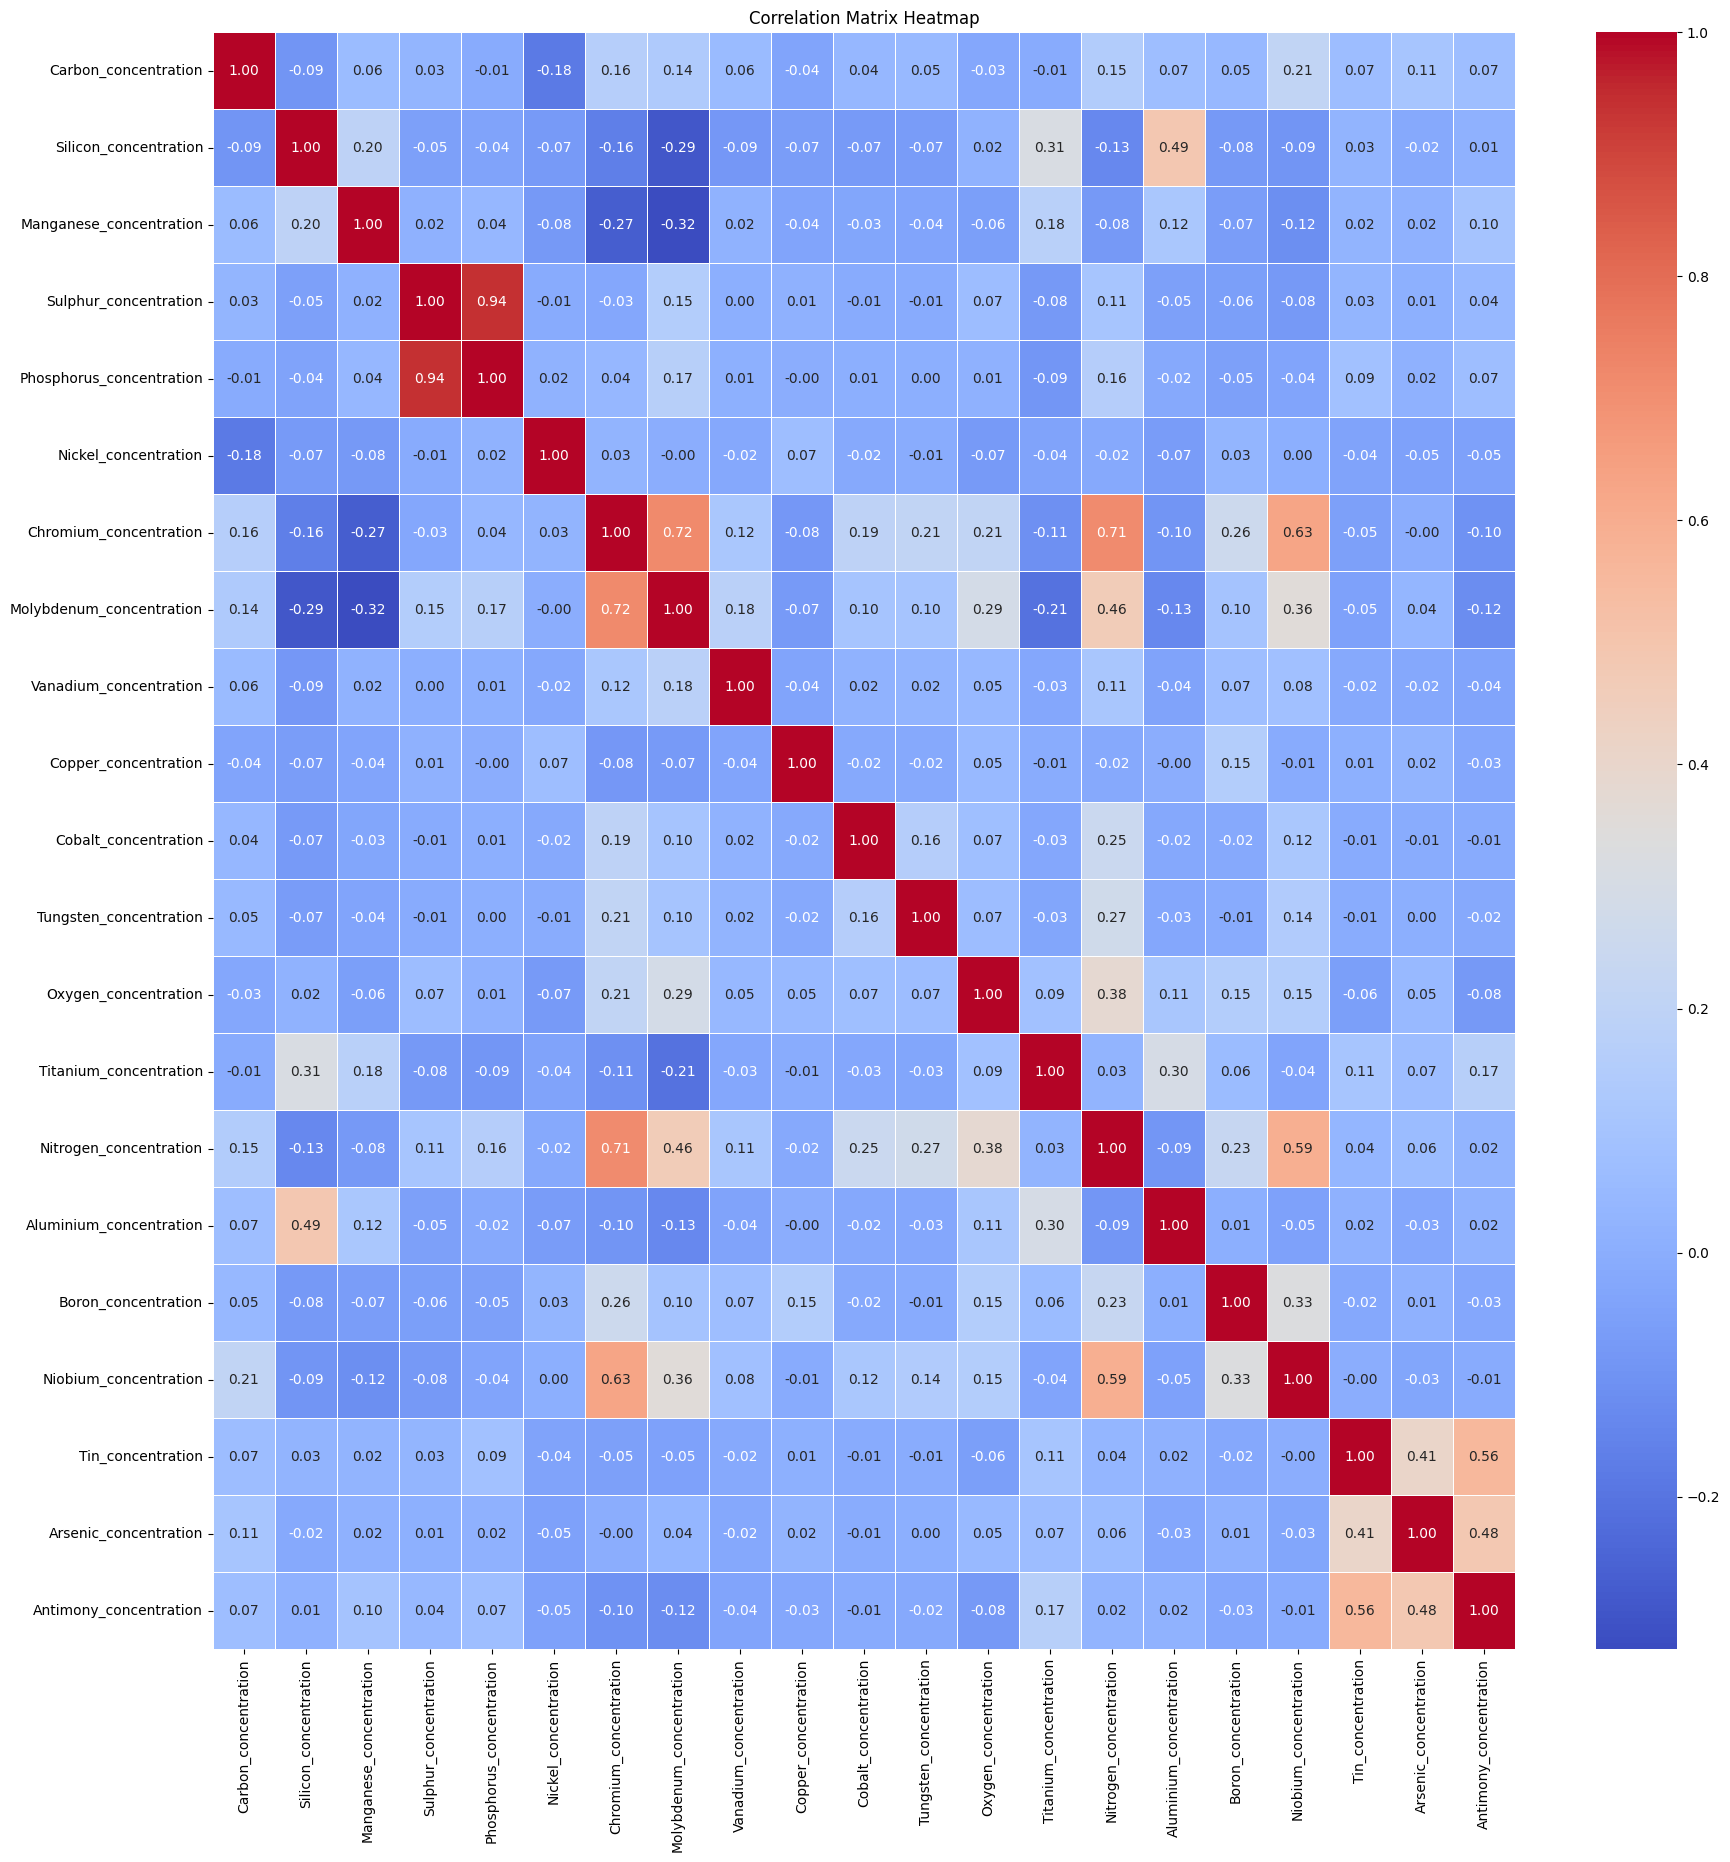

In [426]:
concentration_columns = column_names[0: 21]
correlation_matrix = data_copy[concentration_columns].corr() # By default it is pearson correlation
plt.figure(figsize=(21, 21))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

<div class="alert alert-block alert-info">

- Phosphorus and Sulphur concentrations are deeply correlated

- Molybdenum and Chromimum concentrations are correlated 

The rest seems to be not so much correlated. Maybe we can use a PCA approach to reduce the number of features

According to sckit-learn library, we can use PCA with n_components=0.80 and svd_solver="full"

<b> "If 0 < n_components < 1 and svd_solver == 'full', select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components."</b>

svd_solver = "full" means exact full SVD computes all possible singular values and vectors of the data matrix, even if they might not be needed
</div>

In [428]:
def compute_pca_on_concentrations(df, pca_percent_explained_variance):

    # PCA approach
    pca = PCA(n_components=pca_percent_explained_variance, svd_solver="full")

    # Fit PCA on the DataFrame and transform the data
    vector = pca.fit_transform(df)

    # Results
    explained_variance_ratio = pca.explained_variance_ratio_  # Variance explained by each component
    n_components = pca.n_components_  # Number of components chosen to explain 80% variance

    # Convert the transformed data back to a DataFrame
    pca_data = pd.DataFrame(vector, columns=[f'PC{i+1}' for i in range(n_components)])

    # Print results
    print(f"Number of components chosen by PCA: {n_components}")
    print(f"Explained Variance Ratio: {explained_variance_ratio}")
    return pca_data

pca_data = compute_pca_on_concentrations(data_copy, 0.9)


Number of components chosen by PCA: 5
Explained Variance Ratio: [0.38686345 0.24168806 0.13848677 0.11602297 0.057934  ]


## Scaler

In [429]:
# Normalization or Standardization

def scaler(df, strategy: Literal['standard', 'normalizer']):
    if strategy == 'standard':
        # Instantiate a StandardScaler
        scaler = StandardScaler()
    elif strategy == 'normalizer':
        # Instantiate a Normalizer
        scaler = Normalizer()

    # Normalize the data
    data_scaled = scaler.fit_transform(df)

    # Convert the normalized data to a DataFrame
    data_scaled = pd.DataFrame(data_scaled, columns=df.columns)

    return data_scaled


# Pipeline

In [430]:
OrdinalStrategies = Literal["mean", "linear"]
CategoricalStrategies = Literal["most_frequent", "logistic"]
LessThanValueStrategy = Literal["max", "mean"]
ScalerStrategy = Literal["standard", "normalizer"]


def pipeline_training_set(*, df: pd.DataFrame, labels: list[str], is_PCA: bool,
             pca_percent_explained_variance: float, 
             missing_ordinal_strategy: OrdinalStrategies, missing_categorical_strategy: CategoricalStrategies,
             less_than_value_strategy: LessThanValueStrategy, scaler_strategy: ScalerStrategy) -> tuple[pd.DataFrame, pd.DataFrame]:

    training_set, labels = choose_labels(df, labels)

    # Structural errors
    training_set = replace_data(training_set)

    training_set, labels = process_string_values(inputs=training_set, outputs=labels, labels_chosen=labels, 
                                                 less_than_value_strategy=less_than_value_strategy)

    training_set = convert_to_numeric_values(training_set)

    # Missing values
    ## Transform concentrations accordingly to 
    ## "The yield and ultimate tensile strength of steel welds - Tracey Cool a,*, H.K.D.H. Bhadeshia a, D.J.C. MacKay b"
    training_set = missing_values_sulphur_and_phosphorus(training_set)

    training_set = missing_values_other_concentration(training_set)

    # One Hot Encoding
    training_set, categorical_columns = one_hot_encoding(training_set)

    # Missing values
    training_set = missing_values_physical_properties(training_set, ordinal_strategy=missing_ordinal_strategy, categorical_strategy=missing_categorical_strategy, categorical_columns=categorical_columns)
    
    # Dimension reduction
    concentration_data = training_set[sulphur_and_phosphorus_columns + other_concentration_columns]
    if is_PCA:
        concentration_data = compute_pca_on_concentrations(training_set, pca_percent_explained_variance)
    data_with_feature_selection = pd.concat([concentration_data, training_set[physical_ordinal_properties_columns], training_set[categorical_columns]], axis = 1)

    # Normalization or Standardization
    data_with_feature_selection = scaler(data_with_feature_selection, strategy=scaler_strategy)
    
    return data_with_feature_selection, labels

In [432]:
data_with_feature_selection, labels = pipeline_training_set(df=data, labels="Yield_strength", missing_categorical_strategy="most_frequent", \
                                               missing_ordinal_strategy="mean", is_PCA=True, pca_percent_explained_variance=0.9,
                                               less_than_value_strategy="mean", scaler_strategy="standard")

Number of components chosen by PCA: 5
Explained Variance Ratio: [0.38686345 0.24168806 0.13848677 0.11602297 0.057934  ]


In [433]:
data_with_feature_selection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   PC1                                   1652 non-null   float64
 1   PC2                                   1652 non-null   float64
 2   PC3                                   1652 non-null   float64
 3   PC4                                   1652 non-null   float64
 4   PC5                                   1652 non-null   float64
 5   Current                               1652 non-null   float64
 6   Voltage                               1652 non-null   float64
 7   Heat_input                            1652 non-null   float64
 8   Interpass_temperature                 1652 non-null   float64
 9   Post_weld_heat_treatment_temperature  1652 non-null   float64
 10  Post_weld_heat_treatment_time         1652 non-null   float64
 11  Type_of_weld_SAA 